In [1]:
# ANALISI SHAP DI PRED = 0, PRED = 1

In [1]:
import torch
from transformers import AutoTokenizer

import shap
import pandas as pd
import matplotlib.pyplot as plt

from error_analysis_TRC import load_local_model
from TRC.utils_ea import create_token_dict, get_top_n

/home/cc/venv/rora_venv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/cc/venv/rora_venv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks,

In [2]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'cardiffnlp/twitter-roberta-large-2022-154m'

model_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/config.json'

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-large-2022-154m were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# come input prende una lista di tweet
def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [5]:
explainer = shap.Explainer(f, masker = tokenizer)

In [6]:
df_errati = pd.read_csv('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_errati.csv', index_col = 0)
df_corretti = pd.read_csv('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_corretti.csv', index_col=0)
df_total = pd.concat([df_errati, df_corretti])

In [7]:
df_total.head()

,Tweet,True label,Pred label
0,"@USER @USER that's not good, do you know what ...",1,0
1,Food poisoning in Mandeville HTTPURL,0,1
2,bel bev dabo food poison: HTTPURL via @USER,0,1
3,Douno why my mum trusts me cooking the dinner....,0,1
4,"{Me,My Gist and I} A Couple Died of Food Poiso...",0,1


In [8]:
df_pred_1 = df_total[(df_total['Pred label'] == 1 )]
df_pred_1 = df_pred_1.reset_index()
df_pred_0 = df_total[(df_total['Pred label'] == 0 )]
df_pred_0 = df_pred_0.reset_index()

In [9]:
tweet_pred_1 = df_pred_1['Tweet'].values.tolist()
tweet_pred_0 = df_pred_0['Tweet'].values.tolist()


In [10]:
# CREATION OF SHAP VALUES FOR PRED = 1

In [11]:
shap_values = explainer(tweet_pred_1)
shap_values.shape

Partition explainer: 189it [12:04,  3.92s/it]                         


(188, None, 2)

In [12]:
token_dict = create_token_dict(shap_values, ind_to_get=1)
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)
sorted_d = dict(sorted)

indice di shap preso:  1


[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
to_plot = get_top_n(20, sorted_d)

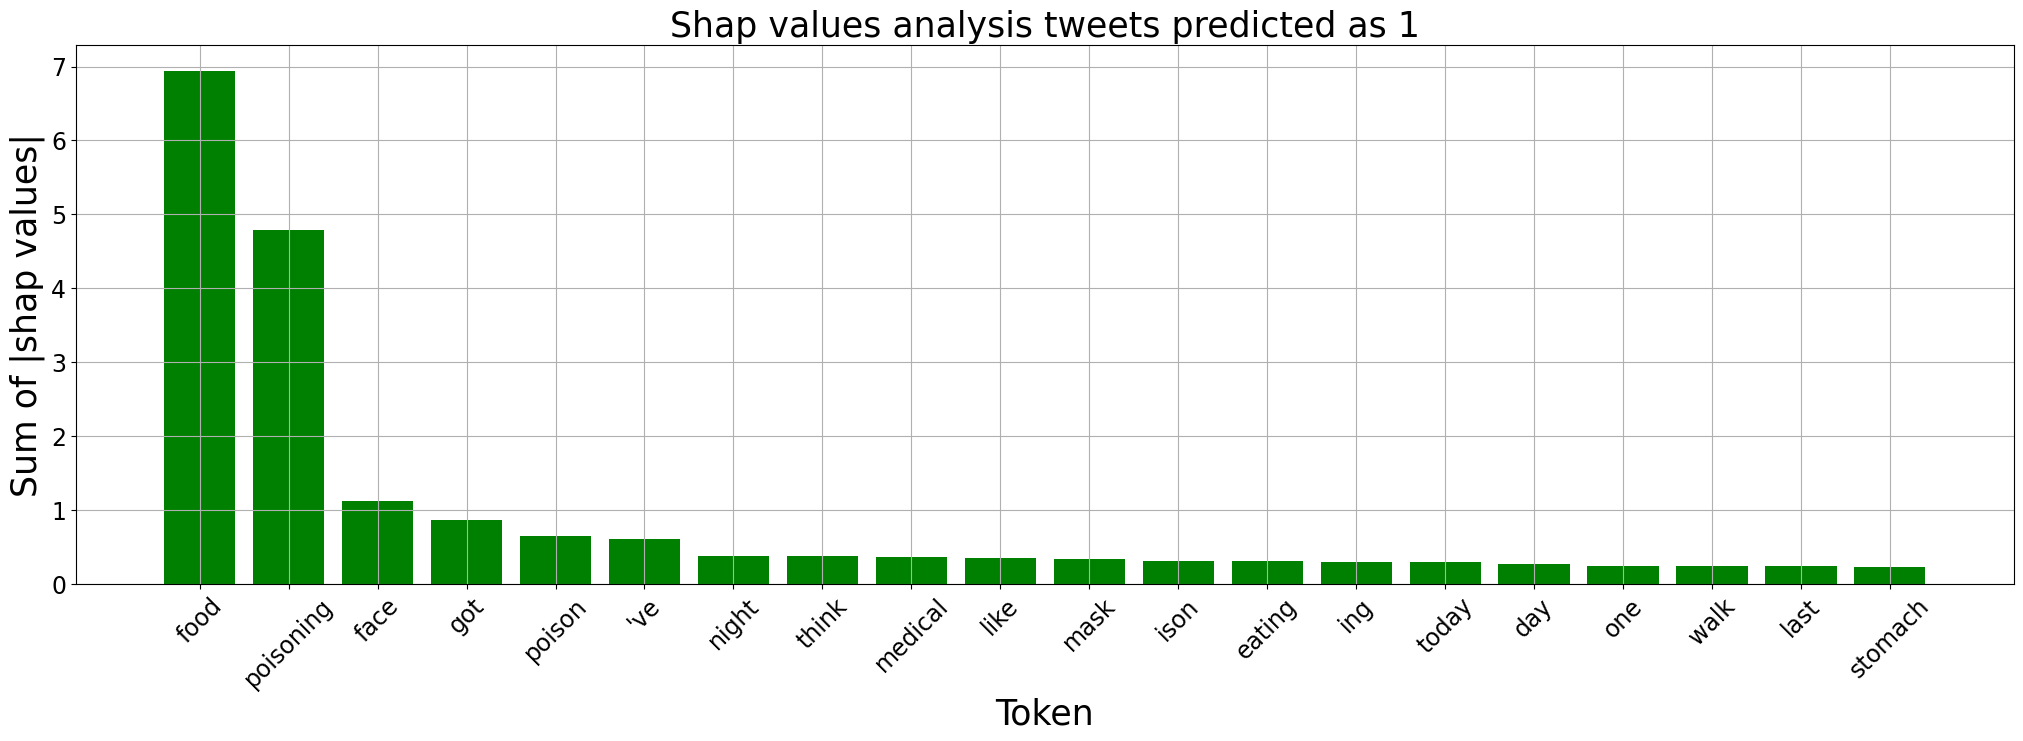

In [14]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()), color = 'green')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis tweets predicted as 1', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of |shap values|', fontsize = 25)
plt.grid()
plt.savefig('shap_pred_1.png',bbox_inches='tight')
plt.show()

In [10]:
# CREATION OF SHAP VALUES FOR PRED = 0

In [10]:
shap_values = explainer(tweet_pred_0)
shap_values.shape

Partition explainer: 225it [15:13,  4.10s/it]                         


(224, None, 2)

In [11]:
token_dict = create_token_dict(shap_values, ind_to_get=0)
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)
sorted_d = dict(sorted)

indice di shap preso:  0


[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
to_plot = get_top_n(20, sorted_d)

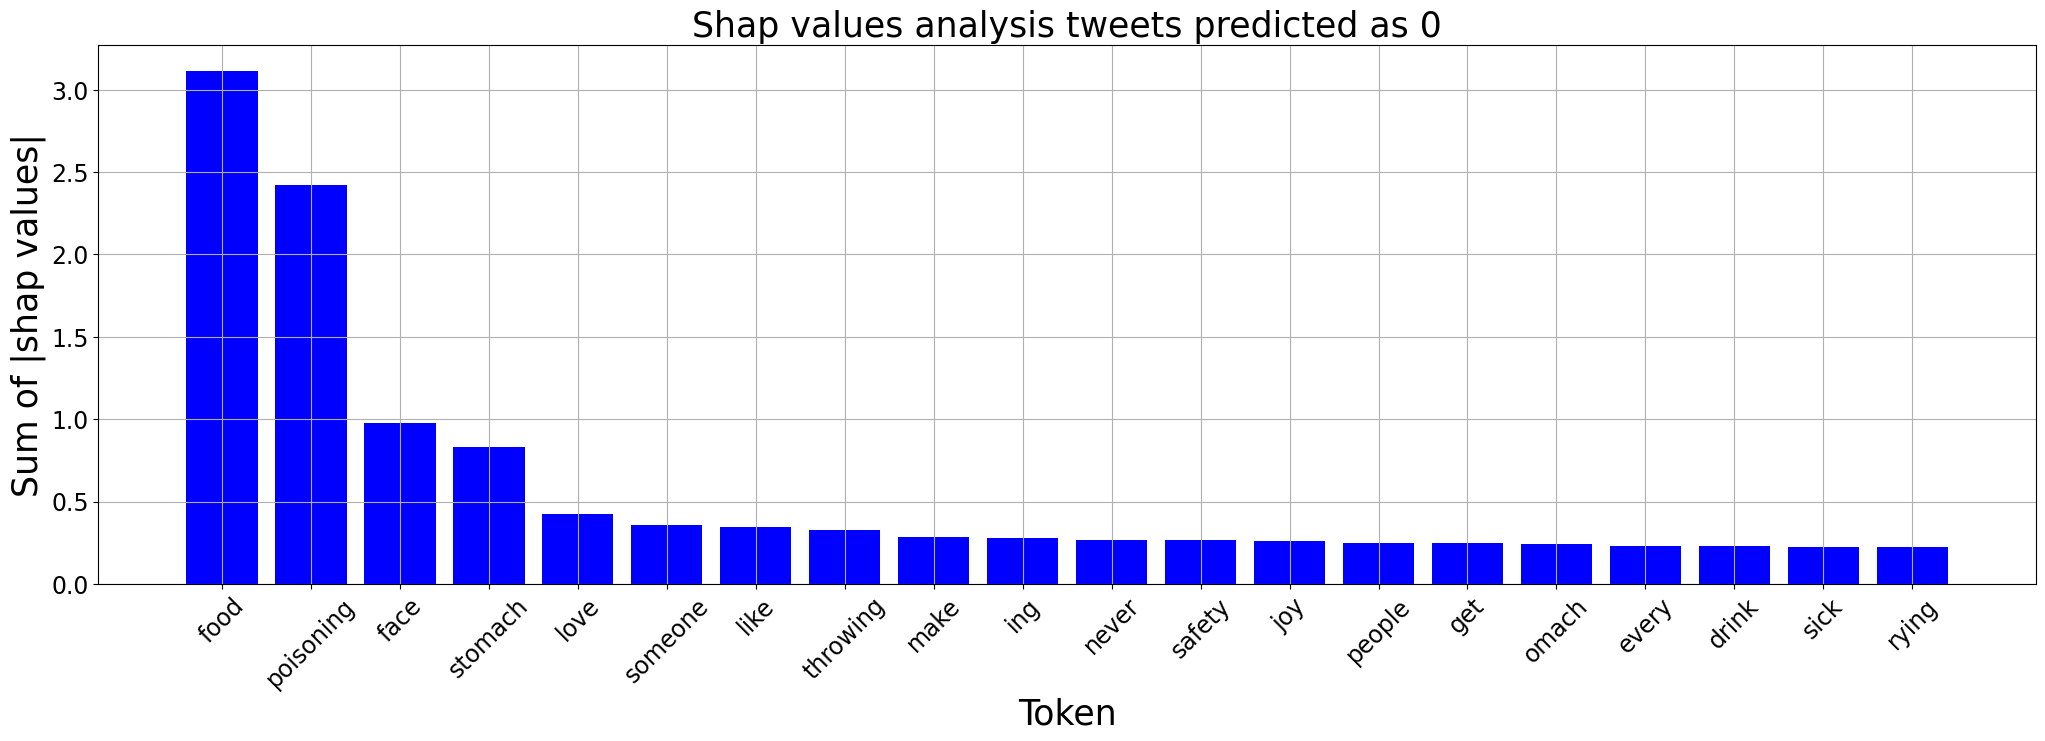

In [14]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()), color = 'blue')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis tweets predicted as 0', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of |shap values|', fontsize = 25)
plt.grid()
plt.savefig('shap_pred_0.png',bbox_inches='tight')
plt.show()